In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("./..")

In [3]:
import numpy as np
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torch.nn.functional as F
import torchvision
import torch.nn as nn
from torch import optim
#
import matplotlib.pyplot as plt
from einops import rearrange
from tqdm import tqdm
#

from misc.plot_utils import plot_mat, imshow
from effcn.layers import FCCaps, FCCapsWOBias
from effcn.utils import count_parameters
from effcn.functions import margin_loss

In [4]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = torch.device(dev)

In [5]:
#!pip install einops

In [6]:
ds_train = datasets.MNIST(
    root = '/mnt/data/pytorch',
    train = True,                         
    transform = T.ToTensor(), 
    download = True,            
)
ds_test = datasets.MNIST(
    root = '/mnt/data/pytorch',
    train = False, 
    transform = T.ToTensor()
)
dl_train = DataLoader(ds_train, batch_size=2, shuffle=False)

In [7]:
transform_train = T.Compose([
    T.RandomRotation(degrees=(-30, 30)),
    T.RandomResizedCrop(
        28,
        scale=(0.8, 1.0),
        ratio=(1, 1),
    ),
    T.RandomAffine(
        degrees=(-30, 30),
        #translate=(0.1, 0.1)
    ),
    T.ToTensor()
])
transform_valid = T.Compose([
    T.ToTensor()
])

In [9]:
ds_train = datasets.MNIST(root='./../data', train=True, download=True, transform=transform_train)
ds_valid = datasets.MNIST(root="./../data", train=False, download=True, transform=transform_valid)
#
dl_train = torch.utils.data.DataLoader(ds_train, 
                                       batch_size=16, 
                                       shuffle=True, 
                                       num_workers=4)
dl_valid = torch.utils.data.DataLoader(ds_valid, 
                                       batch_size=16, 
                                       shuffle=True, 
                                       num_workers=4)

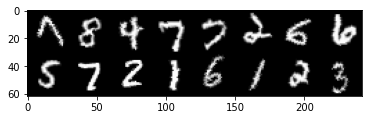

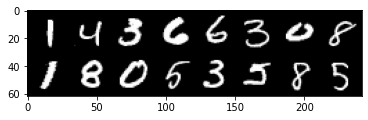

In [10]:
# plot train imgs
x, y = next(iter(dl_train))
img = torchvision.utils.make_grid(x[:64], nrow=8)
img = img.permute((1,2,0))
plt.imshow(img)
plt.show()

# plot valid imgs
x, y = next(iter(dl_valid))
img = torchvision.utils.make_grid(x[:64], nrow=8)
img = img.permute((1,2,0))
plt.imshow(img)
plt.show()

In [15]:
class VisualCapsules(nn.Module):
    def __init__(self, h, w, c, patch_dim, d=32, d_hidden=32):
        super().__init__()
        self.h = h   # img height
        self.w = w   # img width
        self.c = c   # img channels
        self.d = d   # embedding dim
        self.d_hidden = d_hidden   # hidden dimension
        self.patch_dim = patch_dim
        #
        self.n = h//patch_dim * w//patch_dim
        self.patch_size = patch_dim**2 * c
        
        # make sure it adds up
        assert self.n * patch_dim**2 == h * w

        self.pos_emb = nn.Parameter(torch.rand(1, self.n, d), requires_grad=True)
        self.f = nn.Sequential(
            nn.Linear(self.patch_size, self.d),
            #nn.Linear(self.patch_size, d_hidden),
            #nn.GELU(),
            #nn.Linear(d_hidden, d_hidden),
            #nn.GELU(),
            #nn.Linear(d_hidden, self.d)
        )
    def forward(self, x):
        """
            in:  x (b, c, h, w)
            out: (b, patch_size, d)
        """
        batch_size = x.shape[0]
        img_patches = rearrange(
            x, 'b c (patch_x x) (patch_y y) -> b (x y) (patch_x patch_y c)',
                                patch_x=self.patch_dim, patch_y=self.patch_dim)
        img_patches = self.f(img_patches)
        img_patches = img_patches + self.pos_emb
        return img_patches

class MnistCaps(nn.Module):
    def __init__(self, patch_dim=7,d=32):
        super().__init__()
        self.patch_dim = patch_dim
        self.d = d

        self.visualcn = VisualCapsules(28, 28, 1, patch_dim, d)
        self.fccaps = FCCapsWOBias(self.visualcn.n, 10, d, 16)
        
    def forward(self, x):
        x = self.visualcn(x)
        x = self.fccaps(x)
        return x

In [16]:
model = MnistCaps()
model = model.to(device)
print(count_parameters(model))

84032


In [17]:
optimizer = optim.Adam(model.parameters(), lr = 1e-4)

In [ ]:
num_epochs = 101
#
for epoch_idx in range(num_epochs):
    # ####################
    # TRAIN
    # ####################
    model.train()
    desc = "Train [{:3}/{:3}]:".format(epoch_idx, num_epochs)
    pbar = tqdm(dl_train, bar_format=desc + '{bar:10}{r_bar}{bar:-10b}')
    
    for x,y_true in pbar:
        x = x.to(device)
        y_true = y_true.to(device)
        optimizer.zero_grad()
        
        u_h = model.forward(x)
        
        # LOSS
        y_one_hot = F.one_hot(y_true, num_classes=10)
        loss = margin_loss(u_h, y_one_hot)

        loss.backward()
        
        optimizer.step()
        
        y_pred = torch.argmax(torch.norm(u_h, dim=2), dim=1)
        acc = (y_true == y_pred).sum() / y_true.shape[0]
        
        pbar.set_postfix(
                {'loss': loss.item(),
                 'acc': acc.item()
                 }
        )
    #
    # ####################
    # VALID
    # ####################
    if epoch_idx % 5 != 0:
        continue
    
    model.eval()
    
    total_correct = 0
    total = 0

    for x,y_true in dl_valid:
        x = x.to(device)
        y_true = y_true.to(device)
        
        with torch.no_grad():
            u_h = model.forward(x)
            
            y_pred = torch.argmax(torch.norm(u_h, dim=2), dim=1)
            total_correct += (y_true == y_pred).sum()
            total += y_true.shape[0]
    print("   acc_valid: {:.3f}".format(total_correct / total))

Train [  0/101]:██████████| 3750/3750 [00:30<00:00, 122.09it/s, loss=0.283, acc=0.562]                                                       


   acc_valid: 0.819


Train [  1/101]:██████████| 3750/3750 [00:30<00:00, 121.30it/s, loss=0.283, acc=0.5]                                                         
Train [  2/101]:█▋        | 624/3750 [00:05<00:26, 117.65it/s, loss=0.282, acc=0.688]                                                        

In [ ]:
epoch_idx == num_epochs - 1

# Eval

In [ ]:
x.shape

In [ ]:
def imshow(img, cmap="gray", vmin=None, vmax=None):
    npimg = img.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap=cmap, vmin=None, vmax=None)
    plt.show()

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1):
        tensor = tensor.cpu()
        n,c,w,h = tensor.shape

        if allkernels: tensor = tensor.view(n*c, -1, w, h)
        elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

        rows = np.min((tensor.shape[0] // nrow + 1, 64))    
        grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
        plt.figure( figsize=(nrow,rows) )
        plt.imshow(grid.numpy().transpose((1, 2, 0)))
        #return grid

In [ ]:
model.eval()

In [ ]:
U_l.shape

In [ ]:
YY = []
CC = []
UUH = []
UUHSQ = []
UUHFIN = []
UUL = []

for X, Y in dl_valid:
    X = X.to(device)
    U_l = model.visualcn(X)
    U_hat, A, A_scaled, A_sum, C, U_h_fin, U_h_sq = model.fccaps.forward_debug(U_l)
    
    UUL.append(U_l.detach().cpu().numpy())
    UUH.append(U_hat.detach().cpu().numpy())
    YY.append(Y.numpy())
    CC.append(C.detach().cpu().numpy())
    UUHSQ.append(U_h_sq.detach().cpu())
    UUHFIN.append(U_h_fin.detach().cpu())
YY = np.concatenate(YY)
CC = np.concatenate(CC)
UUHSQ = np.concatenate(UUHSQ)
UUHFIN = np.concatenate(UUHFIN)
UUH = np.concatenate(UUH)
UUL = np.concatenate(UUL)

print(YY.shape)
print(CC.shape)

print(U_l.shape)
print(U_hat.shape)
print(A.shape)
print(A_scaled.shape)
print(A_sum.shape)
print(C.shape)
print(U_h_fin.shape)
print(U_h_sq.shape)

In [ ]:
idcs = np.where(YY == 0)
Y = YY[idcs]
C = CC[idcs]
UH = UUH[idcs]
UHS = UUHSQ[idcs]
UHF = UUHFIN[idcs]

In [ ]:
idx = 1
y = Y[idx]
c = C[idx]
uh = UH[idx]
uf = UHF[idx]
#
print(c.shape)
print(uh.shape)
print(uf.shape)

In [ ]:
plot_mat(c, scale_factor=0.4)

In [ ]:
for idx in range(3):
    print("#"*100)
    y = Y[idx]
    c = C[idx]
    uhs = UHS[idx]
    uhf = UHF[idx]
    ul = UUL[idx]
    plot_mat(ul, scale_factor=0.4, title="U_l = lower level capsules")
    plot_mat(c, scale_factor=0.4, title="C")
    plot_mat(uhf, scale_factor=0.4, title="U_h, upper layer capsules w/o squash")
    plot_mat(uhs, scale_factor=0.4, title="squash(U_h)")
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 2))
    axes[0].bar(range(10), c.mean(axis=0))
    axes[0].set_title("C")
    axes[3].bar(range(10), np.linalg.norm(uhs, axis=1))
    axes[3].set_title("sqash(U_h)")
    axes[2].bar(range(10), np.linalg.norm(uhf, axis=1))
    axes[2].set_title("U_h without Squash")
    axes[1].bar(range(16), np.linalg.norm(ul, axis=1))
    axes[1].set_title("U_l")
    plt.show()